In [2]:
import os
import sys
sys.path.append('/Users/aghavamp/Desktop/Projects')
sys.path.append('/Users/aghavamp/Desktop/Projects/bimanual_wrist')
sys.path.append('/Users/aghavamp/Desktop/Projects/Functional_Fusion')
import getpass
import importlib
import tqdm

import scipy.io as sio
import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from pathlib import Path
import seaborn as sns
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel
import glob
import matplotlib.patches as patches

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')


## RELIABILITY of direction encoding

In [3]:
glm = 1
region_labels = [1, 2, 3, 4, 5, 6, 7, 8]
region_names = ['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp']
sn_list = [101,102,103,104,106]
hem = ['L','R']
atlas,_ = am.get_atlas('fs32k')
ana = {'sn':[], 
       'hem':[],
       'region':[],
       'cond':[],
       'r':[],
       'r_corr':[]}
for sn in sn_list:
    regressor_info = pd.read_table(os.path.join(baseDir, f'glm{glm}', f's{sn}', 'reginfo.tsv'))
    partitions = regressor_info['run'].values.flatten()
    conds = regressor_info['name'].values.flatten()
    
    for j, h in enumerate(hem):
        # ==========================================
        # DATA EXTRACTION 
        # ==========================================
        #  Define atlas map
        
        white = os.path.join(baseDir, surfacewbDir, f's{sn}', f's{sn}.{h}.white.32k.surf.gii') # Individual white surface
        pial = os.path.join(baseDir, surfacewbDir, f's{sn}', f's{sn}.{h}.pial.32k.surf.gii') # Invividual pial surface
        mask = os.path.join(baseDir, f'glm{glm}', f's{sn}', 'mask.nii') # Mask in functional space for that subject

        # File names for data extraction
        nii_names = sorted(glob.glob(os.path.join(baseDir, f'glm{glm}', f's{sn}', "beta_*.nii")))
        nii_names = nii_names[0:480] # remove the run constant regressors
        resMS_name = [os.path.join(baseDir, f'glm{glm}', f's{sn}', 'ResMS.nii')]

        beta = []
        resMS = []
        beta_white = []
        for i, r in enumerate(region_labels):
            atlas_tmp = atlas.get_hemisphere(j)
            subatlas = atlas_tmp.get_subatlas_image(os.path.join(atlasDir,f'ROI.32k.{h}.label.gii'), value=r)
            amap = am.AtlasMapSurf(subatlas.vertex[0],white,pial,mask) # Atlas map
            # Compute the voxels in native space
            amap.build()

            # save the ROI mask in native space for checking purposes
            amap.save_as_image(os.path.join(baseDir, regDir, f's{sn}', f'amap_ROI_s{sn}_glm{glm}_{h}_{region_names[i]}.nii'))
            
            # This extract all the relevant voxels in native space (use for RSA)
            beta = amap.extract_data_native(nii_names)
            idx_nan = np.isnan(beta).any(axis=0)
            beta = beta[:, ~idx_nan]
            resMS = amap.extract_data_native(resMS_name)
            resMS = resMS[:, ~idx_nan]
            beta_white = beta/np.sqrt(resMS)
            
            # ========================================== 
            # RELIABILITY ESTIMATION
            # ==========================================
            # left hand:
            idx_left = ['lhand' in tmp for tmp in conds]
            data = beta_white[idx_left,:]
            cond_vec = conds[idx_left]
            part_vec = partitions[idx_left]
            r_corr = np.mean(rel.within_subj_loo(data, cond_vec, part_vec,
                            separate = 'none',
                            subtract_mean=True))
            r = rel.within_subj(data, cond_vec, part_vec,
                            separate = 'none',
                            subtract_mean=True)[0]
            ana['r'].append(r)
            ana['r_corr'].append(r_corr)
            ana['sn'].append(sn)
            ana['hem'].append(h)
            ana['region'].append(region_names[i])
            ana['cond'].append('left')

            # right hand:
            idx_right = ['rhand' in tmp for tmp in conds]
            data = beta_white[idx_right,:]
            cond_vec = conds[idx_right]
            part_vec = partitions[idx_right]
            r_corr = np.mean(rel.within_subj_loo(data, cond_vec, part_vec,
                            separate = 'none',
                            subtract_mean=True))
            r = rel.within_subj(data, cond_vec, part_vec,
                            separate = 'none',
                            subtract_mean=True)[0]
            ana['r'].append(r)
            ana['r_corr'].append(r_corr)
            ana['sn'].append(sn)
            ana['hem'].append(h)
            ana['region'].append(region_names[i])
            ana['cond'].append('right')
            
            # bimanual:
            idx_bimanual = ['bi' in tmp for tmp in conds]
            data = beta_white[idx_bimanual,:]
            cond_vec = conds[idx_bimanual]
            part_vec = partitions[idx_bimanual]
            r_corr = np.mean(rel.within_subj_loo(data, cond_vec, part_vec,
                            separate = 'none',
                            subtract_mean=True))
            r = rel.within_subj(data, cond_vec, part_vec,
                            separate = 'none',
                            subtract_mean=True)[0]
            ana['r'].append(r)
            ana['r_corr'].append(r_corr)
            ana['sn'].append(sn)
            ana['hem'].append(h)
            ana['region'].append(region_names[i])
            ana['cond'].append('bimanual')

ana = pd.DataFrame(ana)
ana.to_csv(os.path.join(analysisDir,'reliability_direction.csv'), index=False)



## RELIABILITY Left vs Right vs Bi

In [4]:
glm = 1
region_labels = [1, 2, 3, 4, 5, 6, 7, 8]
region_names = ['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp']
sn_list = [101,102,103,104,106,107,108,109,110,111,112,113,114,115]
hem = ['L','R']
atlas,_ = am.get_atlas('fs32k')
ana = {'sn':[], 
       'hem':[],
       'region':[],
       'r':[],
       'r_corr':[]}
for sn in sn_list:
    regressor_info = pd.read_table(os.path.join(baseDir, f'glm{glm}', f's{sn}', 'reginfo.tsv'))
    partitions = regressor_info['run'].values.flatten()
    conds = regressor_info['name'].values.flatten()
    conds = np.array([cond.split(':')[0] for cond in conds])
    
    for j, h in enumerate(hem):
        # ==========================================
        # DATA EXTRACTION
        # ==========================================
        #  Define atlas map
        white = os.path.join(baseDir, surfacewbDir, f's{sn}', f's{sn}.{h}.white.32k.surf.gii') # Individual white surface
        pial = os.path.join(baseDir, surfacewbDir, f's{sn}', f's{sn}.{h}.pial.32k.surf.gii') # Invividual pial surface
        mask = os.path.join(baseDir, f'glm{glm}', f's{sn}', 'mask.nii') # Mask in functional space for that subject

        # File names for data extraction
        nii_names = sorted(glob.glob(os.path.join(baseDir, f'glm{glm}', f's{sn}', "beta_*.nii")))
        nii_names = nii_names[0:480] # remove the run constant regressors
        resMS_name = [os.path.join(baseDir, f'glm{glm}', f's{sn}', 'ResMS.nii')]

        beta = []
        resMS = []
        beta_white = []
        for i, r in enumerate(region_labels):
            atlas_tmp = atlas.get_hemisphere(j)
            subatlas = atlas_tmp.get_subatlas_image(os.path.join(atlasDir,f'ROI.32k.{h}.label.gii'), value=r)
            amap = am.AtlasMapSurf(subatlas.vertex[0],white,pial,mask) # Atlas map
            # Compute the voxels in native space
            amap.build()

            # save the ROI mask in native space for checking purposes
            amap.save_as_image(os.path.join(baseDir, regDir, f's{sn}', f'amap_ROI_s{sn}_glm{glm}_{h}_{region_names[i]}.nii'))
            
            # This extract all the relevant voxels in native space (use for RSA)
            beta = amap.extract_data_native(nii_names)
            idx_nan = np.isnan(beta).any(axis=0)
            beta = beta[:, ~idx_nan]
            resMS = amap.extract_data_native(resMS_name)
            resMS = resMS[:, ~idx_nan]
            beta_white = beta/np.sqrt(resMS)
            
            # ========================================== 
            # RELIABILITY ESTIMATION
            # ==========================================
            r_corr = np.mean(rel.within_subj_loo(beta_white, conds, partitions,
                            separate = 'none',
                            subtract_mean=True))
            r = rel.within_subj(beta_white, conds, partitions,
                            separate = 'none',
                            subtract_mean=True)[0]
            ana['r'].append(r)
            ana['r_corr'].append(r_corr)
            ana['sn'].append(sn)
            ana['hem'].append(h)
            ana['region'].append(region_names[i])

ana = pd.DataFrame(ana)
ana.to_csv(os.path.join(analysisDir,'reliability_hand.csv'), index=False)



## Plot

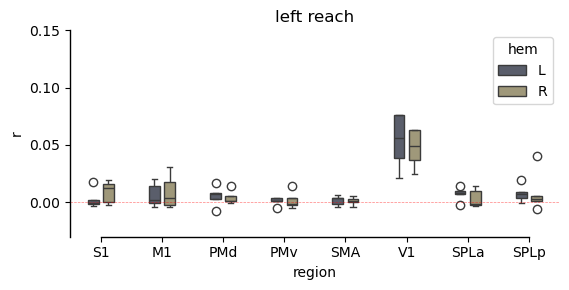

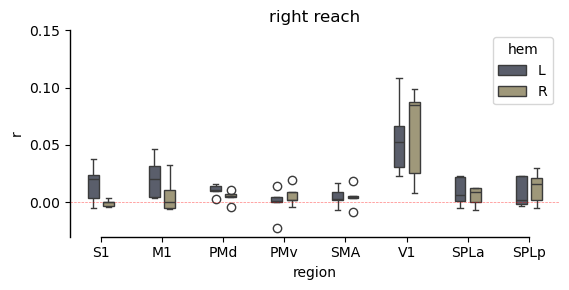

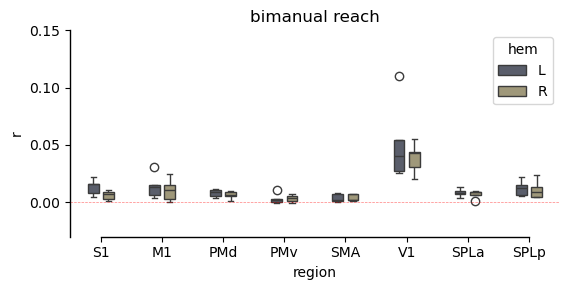

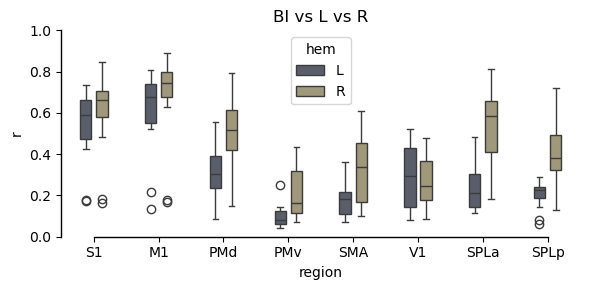

In [4]:
ana_direction = pd.read_csv(os.path.join(analysisDir,'reliability_direction.csv'))
ana_hand = pd.read_csv(os.path.join(analysisDir,'reliability_hand.csv'))

# boxplot reliability:
cond = ['left','right','bimanual']
ana = ana_direction.copy()
for c in cond:
    tmp = ana[(ana['cond'] == c)]
    fig, ax = plt.subplots(figsize=(6,3))
    sns.boxplot(data=tmp, x='region', y='r', hue='hem', ax=ax, width=0.5, gap=0.3, palette='cividis')
    ax.axhline(0, color='red', linestyle='--', alpha=0.5, linewidth=0.5)
    plt.title(f'{c} reach')
    plt.ylim((-0.03,0.15))
    utils.please.make_it_pretty(ax=ax)
    plt.tight_layout()
    plt.savefig(f'../figures/pattern_reliability/{c}_reach.pdf', bbox_inches="tight")
    plt.show()

# boxplot reliability:
ana = ana_hand.copy()
fig, ax = plt.subplots(figsize=(6,3))
sns.boxplot(data=ana, x='region', y='r', hue='hem', ax=ax, width=0.5, gap=0.3, palette='cividis')
ax.axhline(0, color='red', linestyle='--', alpha=0.5, linewidth=0.5)
plt.ylim((0,1))
plt.title(f'BI vs L vs R')
utils.please.make_it_pretty(ax=ax)
plt.tight_layout()
plt.savefig(f'../figures/pattern_reliability/hand_encoding.pdf', bbox_inches="tight")
plt.show()



1) Last plot shows that the encoding of which hand was moved (no matter the direction) is very strong. Right hem seems to have a higher encoding than left hem. All participants were right handed. 

2) Other plots show that the encoding of direction (0,60,120,180,240,300) within left, right, bimanual is very small. Note that this is after subtracting the mean across reach directions. If we don't subtract the mean the reliability value will be around 0.6 to 0.8. This shows that the pattern for different directions were very similar to each other. After subtracting the mean only very subtle (but reliable) differences are there to work with.